# NLP Sentiment Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Bidirectional,
    LSTM,
    Embedding,
    Flatten,
)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_23752\3652020716.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Plot accuracy and loss
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    plt.show()

## Preprocessing

In [3]:
# Read txt files
test_data = pd.read_csv('data/test.txt', delimiter = "\t", names=['sentence'])
train_data = pd.read_csv('data/train.txt', delimiter = "\t", names=['sentence'])

print(train_data.shape, test_data.shape)
print(train_data.head())

(16000, 1) (2000, 1)
                                            sentence
0                    i didnt feel humiliated;sadness
1  i can go from feeling so hopeless to so damned...
2  im grabbing a minute to post i feel greedy wro...
3  i am ever feeling nostalgic about the fireplac...
4                         i am feeling grouchy;anger


In [4]:
# Column for label
train_data['feeling'] = train_data['sentence'].str.split(';').str[1]
test_data['feeling'] = test_data['sentence'].str.split(';').str[1]

# Remove label part in feature
train_data['sentence'] = train_data['sentence'].str.split(';').str[0]
test_data['sentence'] = test_data['sentence'].str.split(';').str[0]

train_data.head()

,sentence,feeling
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
# Check null values
null_values_train = train_data.isnull().sum()
null_values_test = test_data.isnull().sum()

print("Train data:\n", null_values_train)
print("\nTest data:\n", null_values_test)

Train data:
 sentence    0
feeling     0
dtype: int64

Test data:
 sentence    0
feeling     0
dtype: int64


In [6]:
# Check unique labels
unique_label_train = train_data['feeling'].unique()
unique_label_test = test_data['feeling'].unique()

num_label = len(unique_label_train)

print(sorted(unique_label_train))
print(sorted(unique_label_test))

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']


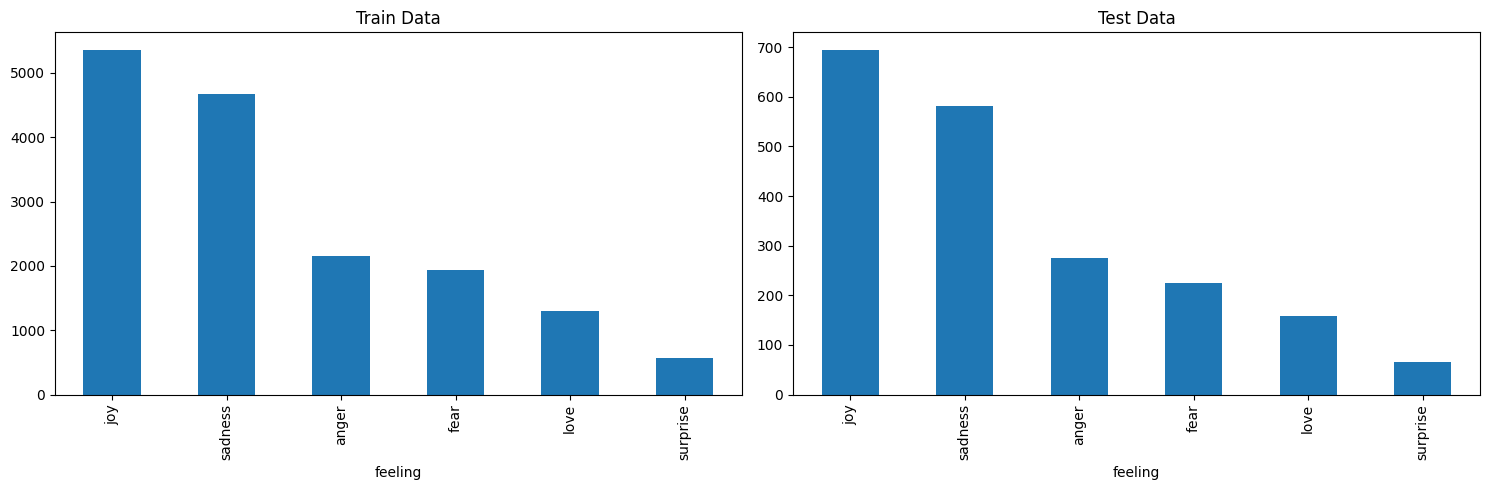

In [7]:
# Plot distribution of labels in train and test data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

train_data['feeling'].value_counts().plot(kind='bar', ax=axes[0], title='Train Data')
test_data['feeling'].value_counts().plot(kind='bar', ax=axes[1], title='Test Data')

plt.tight_layout()
plt.show()

In [8]:
# Convert to list
train_sentences = train_data['sentence'].tolist()
train_labels = train_data['feeling'].tolist()

test_sentences = test_data['sentence'].tolist()
test_labels = test_data['feeling'].tolist()
  
len(train_sentences), len(test_sentences)


(16000, 2000)

In [9]:
# One-Hot Encode labels
encoder = LabelEncoder()

train_labels_encoded = to_categorical(encoder.fit_transform(train_labels))
test_labels_encoded = to_categorical(encoder.fit_transform(test_labels))

train_labels_encoded

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [10]:
# Tokenizer
vocab_size = 10000

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

print(len(train_sequences), len(test_sequences))
print(len(word_index))
print(list(word_index.items())[:10])

16000 2000
15213
[('<OOV>', 1), ('i', 2), ('feel', 3), ('and', 4), ('to', 5), ('the', 6), ('a', 7), ('feeling', 8), ('that', 9), ('of', 10)]


In [11]:
# Padding
max_length = 100

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

print(len(train_padded), len(test_padded))
print(len(train_padded[0]))
print(train_padded[0])

16000 2000
100
[  2 139   3 679   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


## Fully Connected Neural Network

In [12]:
# Model Definition with Embedding in first layer
embedding_dim = 50

model_nn = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_label, activation='softmax')
])

model_nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           500000    
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense (Dense)               (None, 64)                320064    
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 822342 (3.14 MB)
Trainable params: 822342 (3.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# Training
num_epochs = 25

history_nn = model_nn.fit(
    train_padded, 
    train_labels_encoded, 
    epochs=num_epochs,
    batch_size=32, 
    validation_data=(test_padded, test_labels_encoded)
)

Epoch 1/25
500/500 [==============================] - 4s 7ms/step - loss: 1.4093 - accuracy: 0.4324 - val_loss: 0.8199 - val_accuracy: 0.7340
Epoch 2/25
500/500 [==============================] - 3s 7ms/step - loss: 0.4951 - accuracy: 0.8354 - val_loss: 0.5152 - val_accuracy: 0.8305
Epoch 3/25
500/500 [==============================] - 3s 7ms/step - loss: 0.2424 - accuracy: 0.9202 - val_loss: 0.5670 - val_accuracy: 0.8255
Epoch 4/25
500/500 [==============================] - 3s 7ms/step - loss: 0.1388 - accuracy: 0.9578 - val_loss: 0.6289 - val_accuracy: 0.8200
Epoch 5/25
500/500 [==============================] - 3s 6ms/step - loss: 0.0819 - accuracy: 0.9772 - val_loss: 0.7030 - val_accuracy: 0.8150
Epoch 6/25
500/500 [==============================] - 3s 7ms/step - loss: 0.0476 - accuracy: 0.9870 - val_loss: 0.7656 - val_accuracy: 0.8165
Epoch 7/25
500/500 [==============================] - 3s 7ms/step - loss: 0.0282 - accuracy: 0.9929 - val_loss: 0.7973 - val_accuracy: 0.8150
Epoch 

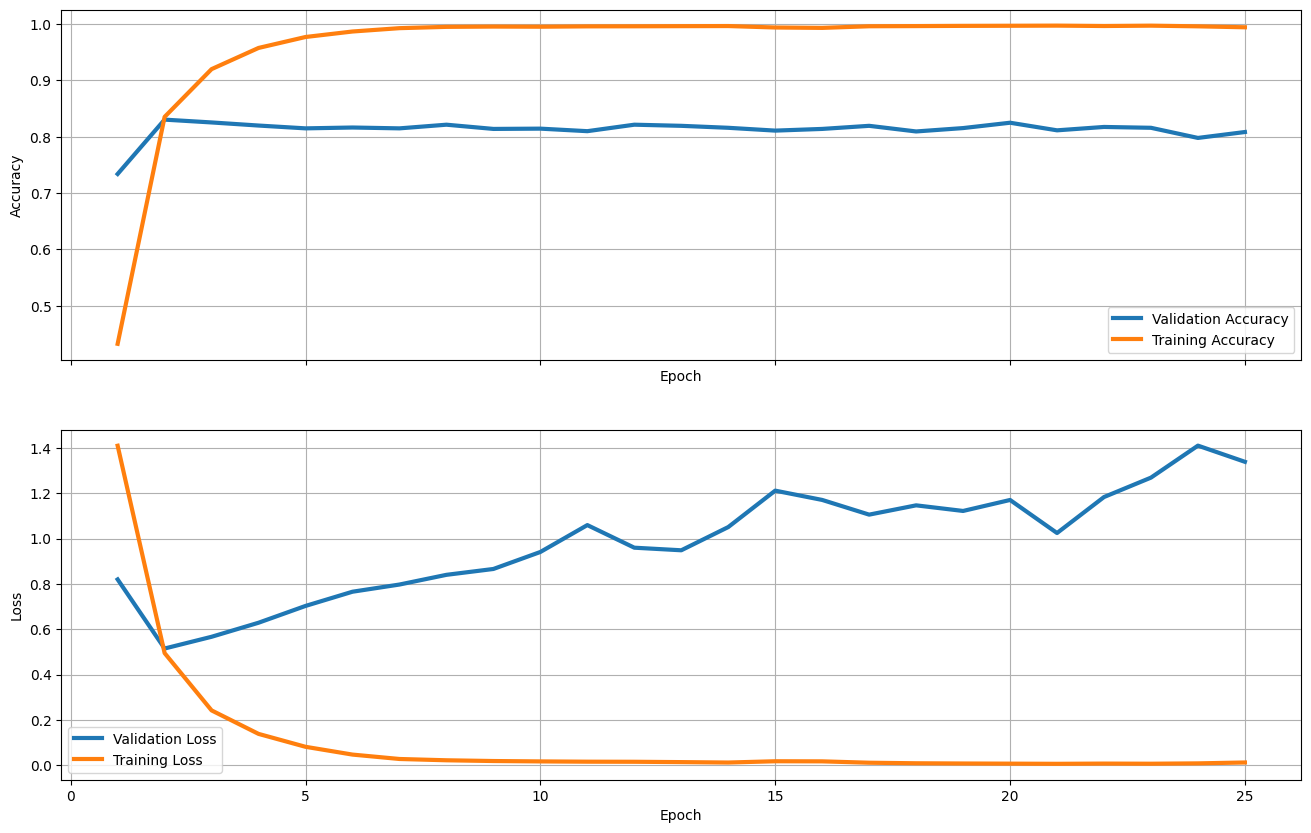

In [14]:
plot_results(history_nn)

In [15]:
# Save the model
model_nn.save('models/nn.h5')

c:\Users\ADMIN\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Recurent Neural Network (LSTM)

In [16]:
# Model Definition with LSTM and Embedding in the first layer
embedding_dim = 50

model_lstm = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(num_label, activation='softmax')
])

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 50)           500000    
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          58880     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 16)               

In [17]:
# Training
num_epochs = 10

history_lstm = model_lstm.fit(
    train_padded, 
    train_labels_encoded, 
    epochs=num_epochs, 
    batch_size=32, 
    validation_data=(test_padded, test_labels_encoded)
)

Epoch 1/10
500/500 [==============================] - 29s 49ms/step - loss: 1.2485 - accuracy: 0.5153 - val_loss: 0.8043 - val_accuracy: 0.7095
Epoch 2/10
500/500 [==============================] - 22s 44ms/step - loss: 0.5962 - accuracy: 0.7862 - val_loss: 0.5813 - val_accuracy: 0.8230
Epoch 3/10
500/500 [==============================] - 23s 45ms/step - loss: 0.3383 - accuracy: 0.8871 - val_loss: 0.3649 - val_accuracy: 0.8810
Epoch 4/10
500/500 [==============================] - 23s 45ms/step - loss: 0.2345 - accuracy: 0.9180 - val_loss: 0.2802 - val_accuracy: 0.9025
Epoch 5/10
500/500 [==============================] - 22s 45ms/step - loss: 0.1606 - accuracy: 0.9471 - val_loss: 0.2959 - val_accuracy: 0.9035
Epoch 6/10
500/500 [==============================] - 23s 45ms/step - loss: 0.1250 - accuracy: 0.9565 - val_loss: 0.2913 - val_accuracy: 0.9140
Epoch 7/10
500/500 [==============================] - 22s 44ms/step - loss: 0.0946 - accuracy: 0.9676 - val_loss: 0.2872 - val_accuracy:

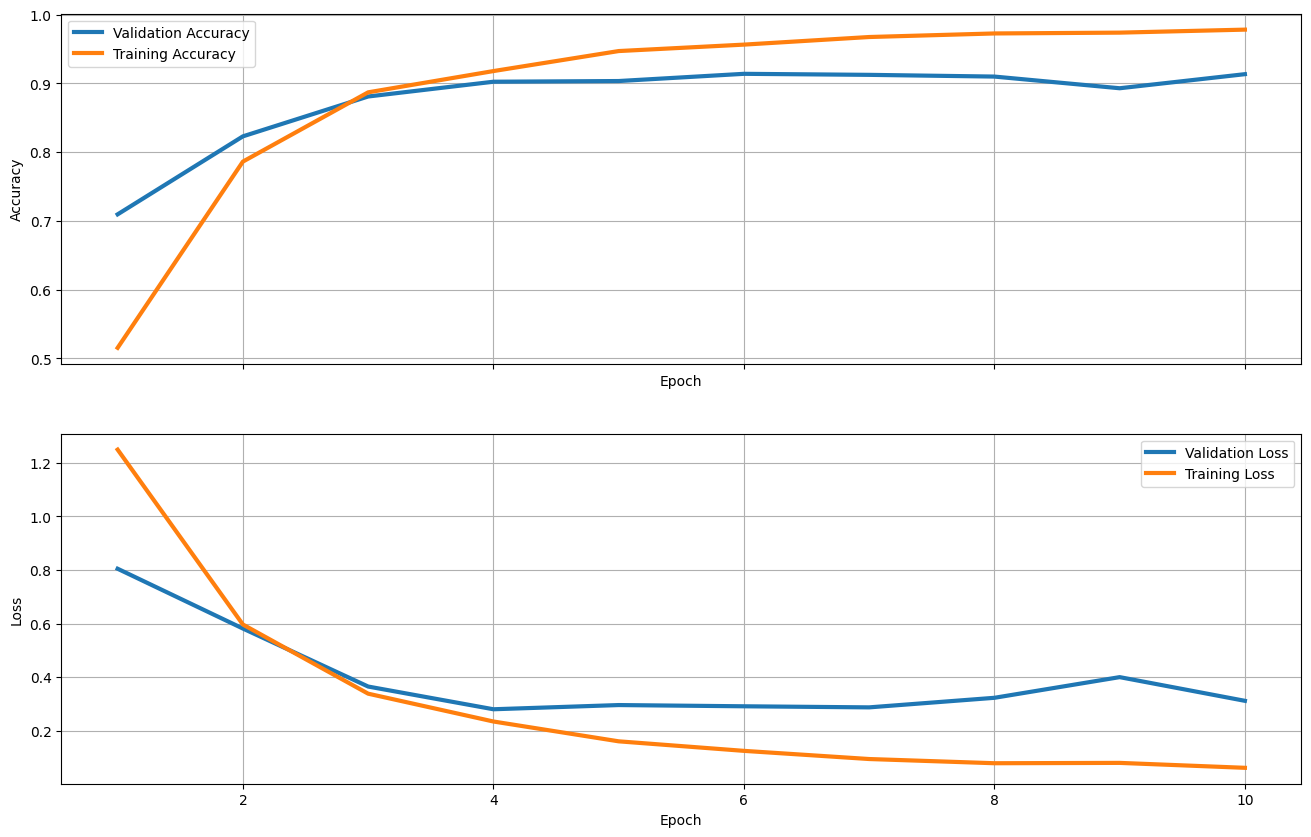

In [18]:
plot_results(history_lstm)

In [19]:
# Save the model
model_lstm.save('models/lstm.h5')

c:\Users\ADMIN\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Fine-tuned Transformer

In [12]:
from transformers import (
    BertTokenizer,
    TFBertModel,
)

c:\Users\ADMIN\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model  = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [14]:
bert_model.trainable = False

In [15]:
input_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32)

bert_output = bert_model(input_ids)

# logits_output = tf.expand_dims(bert_output.logits, axis=1)

net = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(64, return_sequences=True)
)(bert_output[0])

net = tf.keras.layers.Dropout(0.3)(net)

net = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(net)

net = tf.keras.layers.Dropout(0.3)(net)

net = tf.keras.layers.Dense(32, activation="relu")(net)

output = tf.keras.layers.Dense(num_label, activation="softmax")(net)

model = tf.keras.Model(inputs=input_ids, outputs=output)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             100, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

In [17]:
model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

In [20]:
hist = model.fit(
    train_padded,
    train_labels_encoded,
    epochs=10,
    batch_size=128,
    validation_data=(test_padded, test_labels_encoded),
)

Epoch 1/10


125/125 [==============================] - 131s 989ms/step - loss: 1.5777 - accuracy: 0.3339 - val_loss: 1.5609 - val_accuracy: 0.3475
Epoch 2/10
125/125 [==============================] - 123s 978ms/step - loss: 1.5762 - accuracy: 0.3349 - val_loss: 1.5615 - val_accuracy: 0.3475
Epoch 3/10
125/125 [==============================] - 123s 981ms/step - loss: 1.5770 - accuracy: 0.3331 - val_loss: 1.5593 - val_accuracy: 0.3475
Epoch 4/10
125/125 [==============================] - 123s 984ms/step - loss: 1.5769 - accuracy: 0.3353 - val_loss: 1.5617 - val_accuracy: 0.3475
Epoch 5/10
125/125 [==============================] - 123s 978ms/step - loss: 1.5777 - accuracy: 0.3353 - val_loss: 1.5624 - val_accuracy: 0.3475
Epoch 6/10
125/125 [==============================] - 123s 984ms/step - loss: 1.5765 - accuracy: 0.3350 - val_loss: 1.5615 - val_accuracy: 0.3475
Epoch 7/10
125/125 [==============================] - 124s 989ms/step - loss: 1.5763 - accuracy: 0.3351 - val_loss: 1.5636 - val_accura

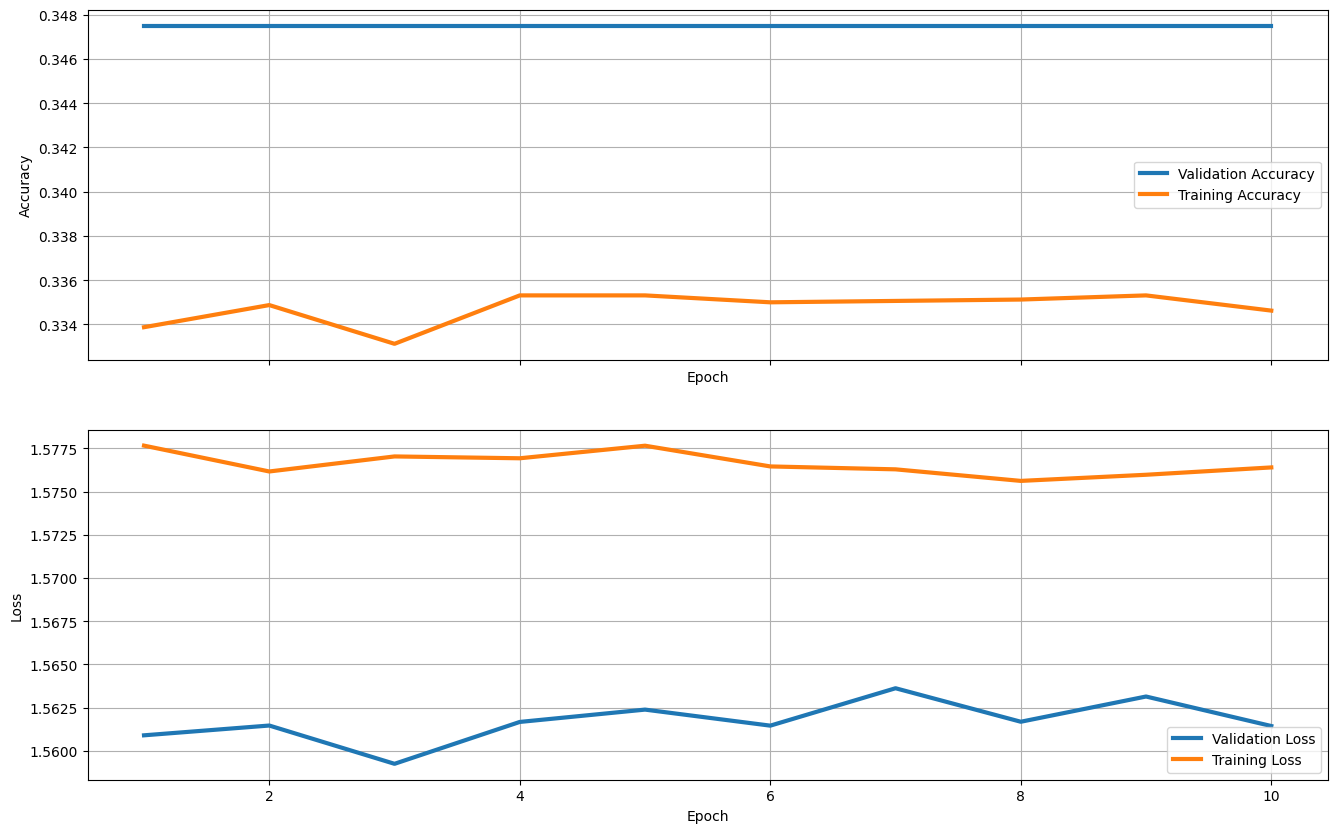

In [22]:
plot_results(hist)

In [21]:
model.save('models/bert.h5')